# RQ4: When all predictors are considered together, which variables contribute the most to predicting affordability?

### Approach

RQ4 asks which variables contribute most when predictors are considered jointly. We evaluate two feature sets:

* **Full:** `median_income + cost_yr + {region_name, geotype, race_eth_name}`
* **NoCost:** `median_income + {region_name, geotype, race_eth_name}`

We fit several model families using a fixed train/test split and select the best-performing model within each feature set. To quantify each variable’s contribution, we use **permutation importance** on the held-out test set.

**Note:** If `cost_yr` is mechanically related to how `affordability_ratio` is constructed, it may dominate importance and inflate performance in the Full setting. The NoCost setting helps isolate how much predictive signal remains in income + contextual variables alone.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from utils.model_utils import rmse, make_ohe, split_cols, make_preprocessor, wrap_log1p, eval_model_rq4

RANDOM_STATE = 159
np.random.seed(RANDOM_STATE)

DATA_PATH = Path("./data/food_affordability.csv")
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

TARGET = "affordability_ratio"

In [2]:
df = pd.read_csv(DATA_PATH)

# Define feature sets
CONTEXT_FEATURES = ["region_name", "geotype", "race_eth_name"]
FULL_FEATURES    = ["median_income", "cost_yr"] + CONTEXT_FEATURES
NOCOST_FEATURES  = ["median_income"] + CONTEXT_FEATURES

ALL_USED = sorted(set([TARGET] + FULL_FEATURES + NOCOST_FEATURES))
df_m = df.dropna(subset=ALL_USED).copy()

print("Rows kept:", df_m.shape[0])
df_m[ALL_USED].head()

Rows kept: 3473


,affordability_ratio,cost_yr,geotype,median_income,race_eth_name,region_name
0,0.315779,7508.289655,CA,23777.0,AIAN,California
1,0.194980,7508.289655,CA,38508.0,Asian,California
2,0.286664,7508.289655,CA,26192.0,AfricanAm,California
3,0.328475,7508.289655,CA,22858.0,Latino,California
4,0.204379,7508.289655,CA,36737.0,NHOPI,California


In [3]:
X_all = df_m[sorted(set(FULL_FEATURES + NOCOST_FEATURES))].copy()
y = df_m[TARGET].copy()

idx = np.arange(len(df_m))
idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=RANDOM_STATE)

X_train_all, X_test_all = X_all.iloc[idx_train], X_all.iloc[idx_test]
y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]

X_train_all.shape, X_test_all.shape

((2778, 5), (695, 5))

In [4]:
feature_sets = {
    "RQ4-Full (income+cost+context)": FULL_FEATURES,
    "RQ4-NoCost (income+context)": NOCOST_FEATURES
}

rows = []
best_models = {}
all_preds = {}

for fs_name, feats in feature_sets.items():
    Xtr = X_train_all[feats]
    Xte = X_test_all[feats]

    # Baseline
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(Xtr, y_train)
    pred_dummy = dummy.predict(Xte)
    rows.append({
        "feature_set": fs_name,
        "model": "Dummy(mean)",
        "RMSE": rmse(y_test, pred_dummy),
        "MAE": float(mean_absolute_error(y_test, pred_dummy)),
        "R2":  float(r2_score(y_test, pred_dummy))
    })
    all_preds[(fs_name, "Dummy(mean)")] = pred_dummy

    # Linear (good baseline)
    pre_lin = make_preprocessor(feats, X_train_all, dense=False, scale_num_for_linear=True)
    lin = wrap_log1p(Pipeline([("pre", pre_lin), ("lin", LinearRegression())]))
    m_lin, pred_lin = eval_model_rq4(lin, Xtr, Xte, y_train, y_test)
    rows.append({"feature_set": fs_name, "model": "Linear(log1p y)", **m_lin})
    all_preds[(fs_name, "Linear(log1p y)")] = pred_lin

    # Random Forest
    pre_tree = make_preprocessor(feats, X_train_all, dense=False, scale_num_for_linear=False)
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        min_samples_leaf=2
    )
    rf_m = wrap_log1p(Pipeline([("pre", pre_tree), ("rf", rf)]))
    m_rf, pred_rf = eval_model_rq4(rf_m, Xtr, Xte, y_train, y_test)
    rows.append({"feature_set": fs_name, "model": "RandomForest(log1p y)", **m_rf})
    all_preds[(fs_name, "RandomForest(log1p y)")] = pred_rf

    pre_hgb = make_preprocessor(feats, X_train_all, dense=True, scale_num_for_linear=False)
    hgb = HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        max_depth=6,
        learning_rate=0.05,
        max_iter=400
    )
    hgb_m = wrap_log1p(Pipeline([("pre", pre_hgb), ("hgb", hgb)]))
    m_hgb, pred_hgb = eval_model_rq4(hgb_m, Xtr, Xte, y_train, y_test)
    rows.append({"feature_set": fs_name, "model": "HistGB(log1p y)", **m_hgb})
    all_preds[(fs_name, "HistGB(log1p y)")] = pred_hgb

metrics_rq4 = pd.DataFrame(rows).sort_values(["feature_set", "RMSE"])
metrics_rq4

,feature_set,model,RMSE,MAE,R2
2,RQ4-Full (income+cost+context),RandomForest(log1p y),0.023730,0.006445,0.996411
3,RQ4-Full (income+cost+context),HistGB(log1p y),0.027553,0.009115,0.995162
1,RQ4-Full (income+cost+context),Linear(log1p y),0.340012,0.145797,0.263215
0,RQ4-Full (income+cost+context),Dummy(mean),0.396309,0.219434,-0.000969
7,RQ4-NoCost (income+context),HistGB(log1p y),0.084735,0.037181,0.954241
6,RQ4-NoCost (income+context),RandomForest(log1p y),0.094195,0.039957,0.943453
5,RQ4-NoCost (income+context),Linear(log1p y),0.337358,0.145718,0.274672
4,RQ4-NoCost (income+context),Dummy(mean),0.396309,0.219434,-0.000969


Tree-based models strongly outperform the linear baseline. With the Full feature set, Random Forest achieves near-perfect performance (R² ≈ 0.996; RMSE ≈ 0.024), while without `cost_yr`, the best model (HistGradientBoosting) still performs very well (R² ≈ 0.954; RMSE ≈ 0.085). The linear model remains around R² ≈ 0.26–0.27, indicating that nonlinear models capture structure that linear regression does not.

**Note:** Because `cost_yr` may be mechanically related to `affordability_ratio` (depending on how the affordability ratio was constructed), the extremely high R² in the Full setting should be interpreted cautiously as potentially reflecting a definitional/structural relationship rather than purely “discovering” new predictive patterns.

In [5]:
# Save metrics
metrics_rq4.to_csv(OUT_DIR / "rq4_model_metrics.csv", index=False)

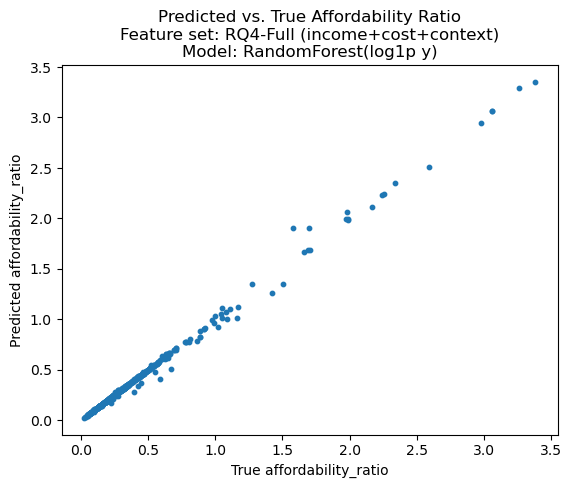


=== Permutation importance: RQ4-Full (income+cost+context) | RandomForest(log1p y) ===



,feature,importance_mean,importance_std
0,median_income,2.297895,0.130425
1,cost_yr,0.135856,0.024027
2,region_name,0.000696,0.000430
4,race_eth_name,0.000067,0.000039
3,geotype,0.000043,0.000042


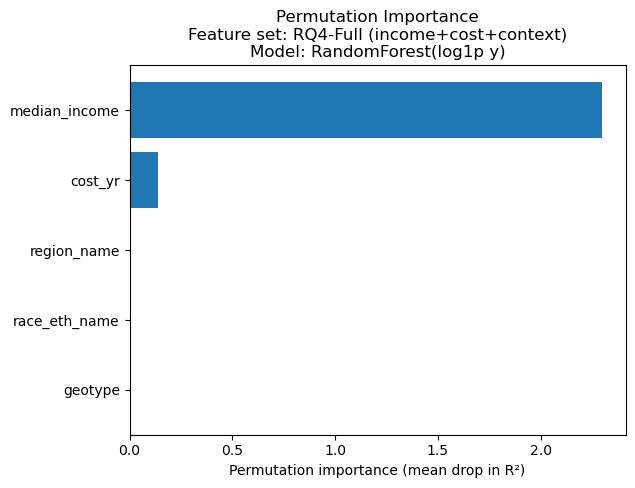

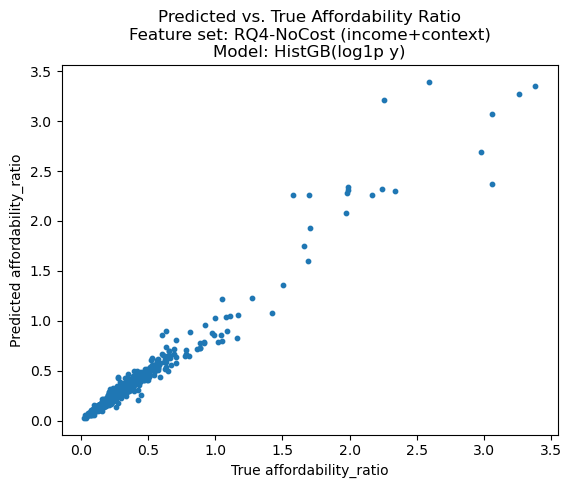


=== Permutation importance: RQ4-NoCost (income+context) | HistGB(log1p y) ===



,feature,importance_mean,importance_std
0,median_income,2.081926,0.093943
1,region_name,0.060948,0.019441
3,race_eth_name,0.008749,0.006657
2,geotype,0.000395,0.000102


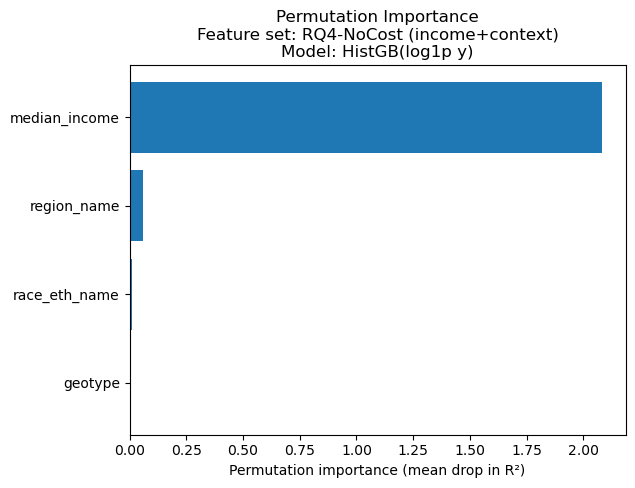

In [6]:
def pick_best(df_metrics, fs_name):
    sub = df_metrics[df_metrics["feature_set"] == fs_name].copy()
    sub = sub.sort_values("RMSE")
    return sub.iloc[0]["model"]

for fs_name, feats in feature_sets.items():
    best_model_name = pick_best(metrics_rq4, fs_name)
    preds = all_preds[(fs_name, best_model_name)]

    # Rebuild and refit the best model (so we can run permutation importance cleanly)
    Xtr = X_train_all[feats]
    Xte = X_test_all[feats]

    if best_model_name.startswith("Linear"):
        pre = make_preprocessor(feats, X_train_all, dense=False, scale_num_for_linear=True)
        best = wrap_log1p(Pipeline([("pre", pre), ("lin", LinearRegression())]))
    elif best_model_name.startswith("RandomForest"):
        pre = make_preprocessor(feats, X_train_all, dense=False, scale_num_for_linear=False)
        best = wrap_log1p(Pipeline([("pre", pre), ("rf", RandomForestRegressor(
            n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1, min_samples_leaf=2
        ))]))
    elif best_model_name.startswith("HistGB"):
        pre = make_preprocessor(feats, X_train_all, dense=True, scale_num_for_linear=False)
        best = wrap_log1p(Pipeline([("pre", pre), ("hgb", HistGradientBoostingRegressor(
            random_state=RANDOM_STATE, max_depth=6, learning_rate=0.05, max_iter=400
        ))]))
    else:
        continue

    best.fit(Xtr, y_train)

    # Pred vs True
    plt.figure()
    plt.scatter(y_test, preds, s=10)
    plt.xlabel("True affordability_ratio")
    plt.ylabel("Predicted affordability_ratio")
    plt.title(
    f"Predicted vs. True Affordability Ratio\n"
    f"Feature set: {fs_name}\n"
    f"Model: {best_model_name}"
)

    fig_path = FIG_DIR / f"rq4_pred_vs_true__{fs_name.split()[0].lower()}__{best_model_name.split('(')[0].lower()}.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()

    # Permutation importance on RAW features (region/geotype/race/income/cost)
    imp = permutation_importance(
        best,
        Xte,
        y_test,
        n_repeats=20,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring="r2"
    )

    imp_df = pd.DataFrame({
        "feature": Xte.columns,
        "importance_mean": imp.importances_mean,
        "importance_std": imp.importances_std,
    }).sort_values("importance_mean", ascending=False)

    print("\n=== Permutation importance:", fs_name, "|", best_model_name, "===\n")
    display(imp_df)

    # Save + plot
    out_csv = OUT_DIR / f"rq4_perm_importance__{fs_name.split()[0].lower()}__{best_model_name.split('(')[0].lower()}.csv"
    imp_df.to_csv(out_csv, index=False)

    plt.figure()
    plt.barh(imp_df["feature"][::-1], imp_df["importance_mean"][::-1])
    plt.xlabel("Permutation importance (mean drop in R²)")
    plt.title(
    f"Permutation Importance\n"
    f"Feature set: {fs_name}\n"
    f"Model: {best_model_name}"
    )
    out_fig = FIG_DIR / f"rq4_perm_importance__{fs_name.split()[0].lower()}__{best_model_name.split('(')[0].lower()}.png"
    plt.savefig(out_fig, dpi=150, bbox_inches="tight")
    plt.show()

Permutation importance (measured as mean drop in test R² when a feature is permuted) shows that **median_income dominates** in both settings.  
- In the **Full** model, `median_income` is by far the largest driver, with `cost_yr` as a distant second; `region_name`, `race_eth_name`, and `geotype` contribute negligibly.  
- In the **NoCost** model, `median_income` remains dominant; `region_name` becomes the next most informative feature, while `race_eth_name` is small and `geotype` is near zero.

Overall, when all predictors are considered together, **income is the primary driver**, and **cost (when included) adds additional predictive power**, while geographic/race context variables contribute comparatively little in this dataset/modeling setup.
